In [1]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd
import pymc as pm
import sys
import arviz as az
import pickle

with open('trace', 'rb') as f:
    loaded_data = pickle.load(f)

# switchpoints: 这里还未处理完，还没把四条轨迹合并
switchpoints1 = np.array(loaded_data.posterior.switchpoints)
np.shape(switchpoints1)

#switchpoints1是中级变量，后面经过处理的switchpoints才是最终的结果
#如果也用switchpoints是不对的，这样再重复运行第二个模块时会出问题

(4, 80000, 8)

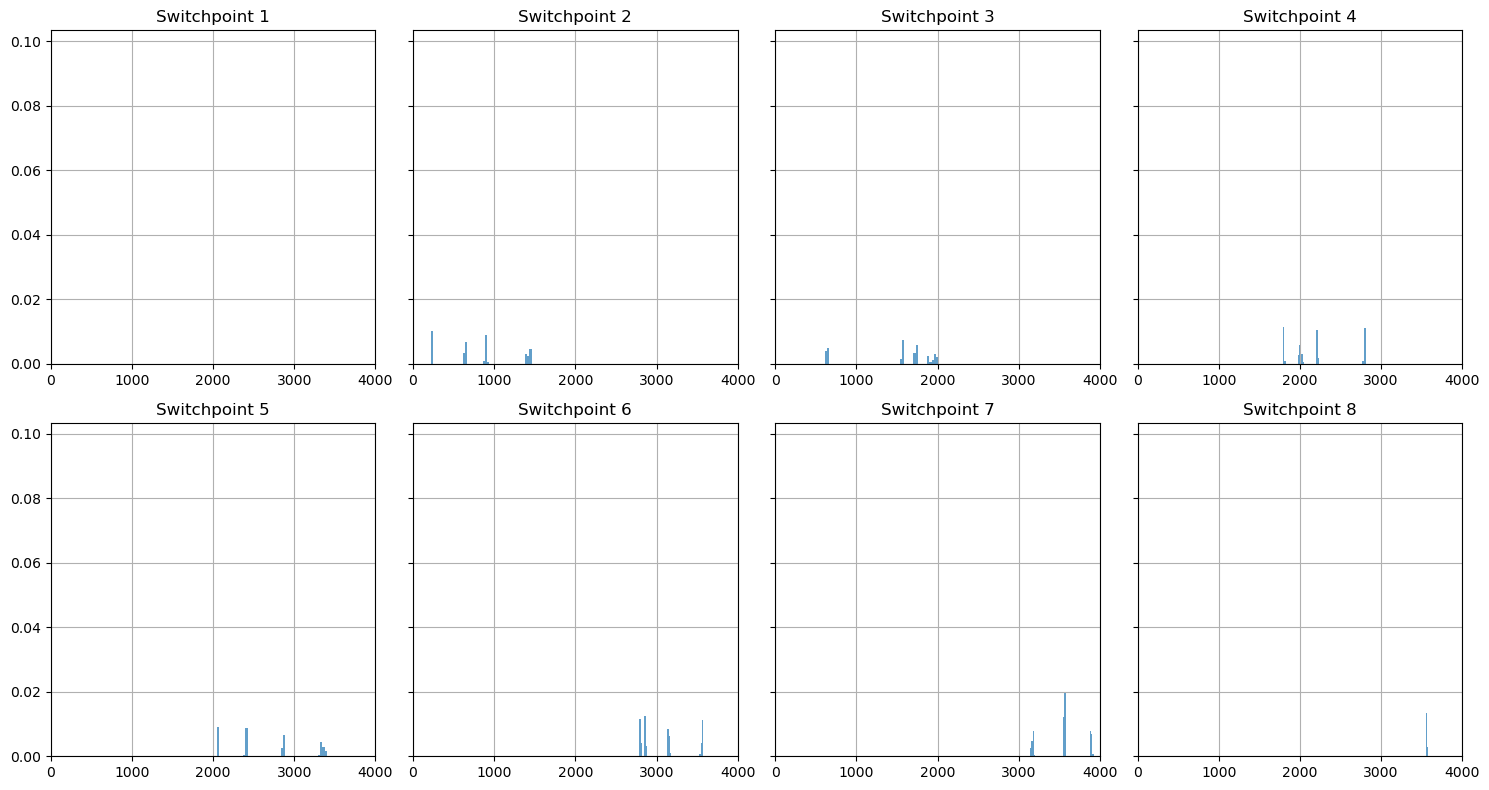

In [2]:
ns = 8

# 假设您的 switchpoints 数组已经定义
# switchpoints = np.random.randn(8, 10000)  # 例如，使用随机数据代替
tmp1 = switchpoints1.reshape(320000,ns)
tmp2 = tmp1.T

# 假设您的 switchpoints 数组已经定义
# switchpoints = np.random.randn(5, 10000)  # 例如，使用随机数据代替
switchpoints = tmp2 #switchpoints: dims = 320000 * 8

# 创建一个图表和坐标轴对象，2行4列的子图布局
fig, axs = plt.subplots(2, 4, figsize=(15, 8), sharey=True)

# 遍历每个维度，绘制分布直方图，并设置横坐标范围
for i in range(ns):
    row = i // 4  # 行索引
    col = i % 4   # 列索引
    n, bins, patches = axs[row, col].hist(switchpoints[i], bins=50, density=True, alpha=0.7)
    axs[row, col].set_title(f'Switchpoint {i+1}')
    axs[row, col].set_xlim(0, 4000)  # 设置横坐标范围
    axs[row, col].grid(True)

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

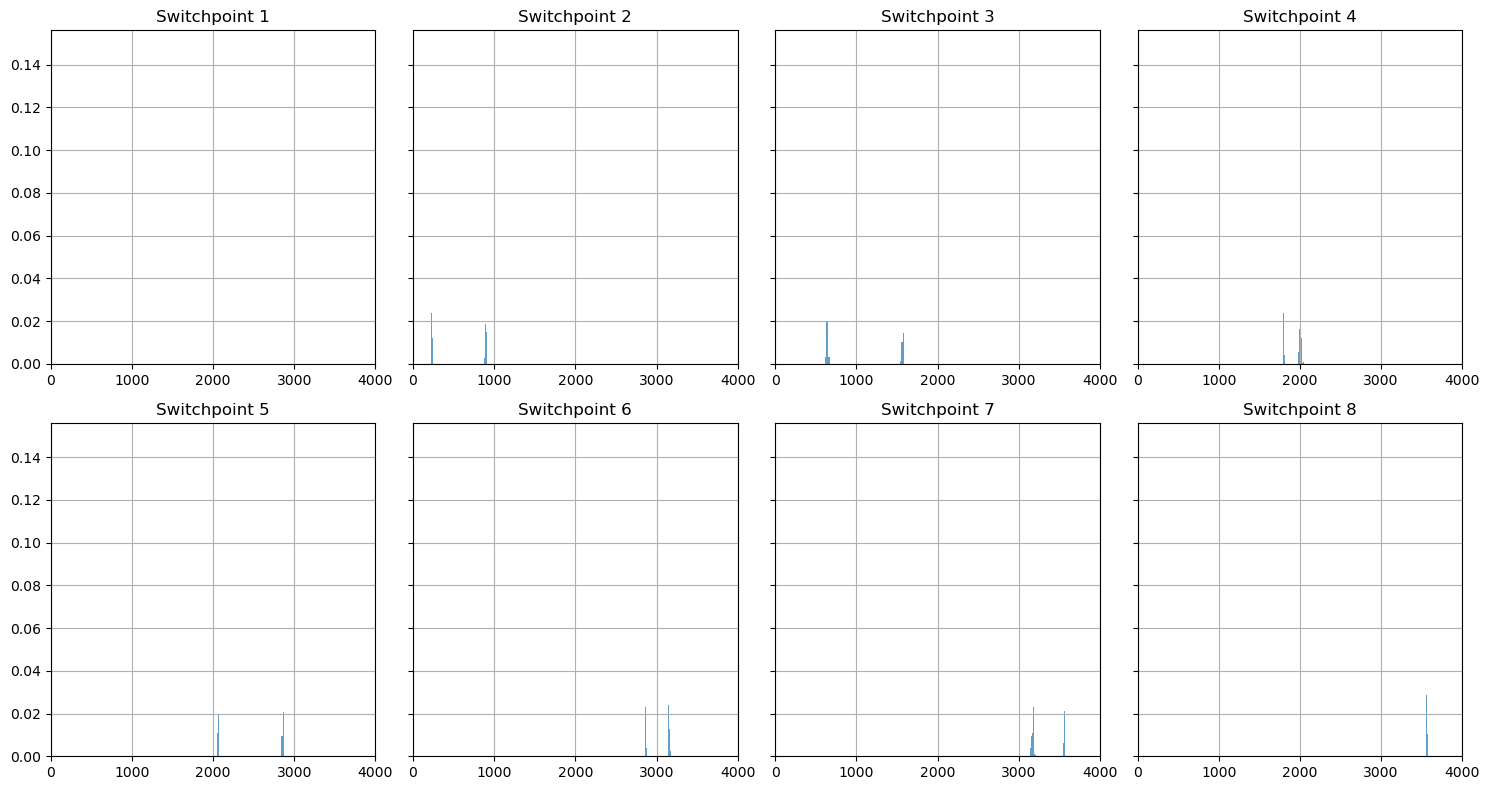

In [3]:
switchpoints_b = switchpoints[:,160000:]

# 创建一个图表和坐标轴对象，2行4列的子图布局
fig, axs = plt.subplots(2, 4, figsize=(15, 8), sharey=True)

# 遍历每个维度，绘制分布直方图，并设置横坐标范围
for i in range(ns):
    row = i // 4  # 行索引
    col = i % 4   # 列索引
    n, bins, patches = axs[row, col].hist(switchpoints_b[i], bins=50, density=True, alpha=0.7)
    axs[row, col].set_title(f'Switchpoint {i+1}')
    axs[row, col].set_xlim(0, 4000)  # 设置横坐标范围
    axs[row, col].grid(True)

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()


In [4]:
# 计算分布
def cal_dist(data):
    # num_bins: time bins 个数
    num_bins = 10000
    
    histograms = np.zeros((8, num_bins))

    for i in range(8):
        histograms[i], _ = np.histogram(data[i], bins = num_bins, range= (0,4358))
    return histograms / np.sum(histograms, axis=1, keepdims=True)


dist = cal_dist(switchpoints)
print(np.shape(dist))
print(dist)

(8, 10000)
[[0.03431563 0.03712812 0.03938125 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [5]:
# 计算后半截的分布

def cal_dist(data):
    # num_bins: time bins 个数
    num_bins = 10000
    
    histograms = np.zeros((ns, num_bins))

    for i in range(ns):
        histograms[i], _ = np.histogram(data[i], bins = num_bins, range= (0,4358))
    return histograms / np.sum(histograms, axis=1, keepdims=True)


dist_b = cal_dist(switchpoints_b) # dist_b 则是计算后半段的dist的熵的量
print(np.shape(dist))
print(dist_b)

(8, 10000)
[[0.04404375 0.0522625  0.05835    ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [6]:
# 计算每个分量的方差
variances = np.var(switchpoints, axis=1)

# 计算每个分量的熵
def entropy(p):
    values = np.zeros_like(p)
    non_zero_indices = p != 0
    values[non_zero_indices] = -np.sum(p[non_zero_indices] * np.log2(p[non_zero_indices]))
    return values
    
# entropies_p:entropies of probabilities: dims=num_bins * 8 * 1
# entropies_d:entropies of distribution: dims=8 * 1
entropies_p = np.apply_along_axis(entropy, axis=1, arr=dist)
entropies_d = np.sum(entropies_p, axis=1, keepdims=True)
# 输出结果
for i in range(8):
    print(f"Switchpoint {i+1}: Variance = {variances[i]}, Entropy = {entropies_d[i]}")

Switchpoint 1: Variance = 39.72373438739354, Entropy = [275.09816677]
Switchpoint 2: Variance = 188403.89488337975, Entropy = [2948.64056895]
Switchpoint 3: Variance = 248984.980879645, Entropy = [4706.11227741]
Switchpoint 4: Variance = 139438.50017095444, Entropy = [2487.72701338]
Switchpoint 5: Variance = 234540.67441941195, Entropy = [2902.62293084]
Switchpoint 6: Variance = 90484.73821734243, Entropy = [2350.1189812]
Switchpoint 7: Variance = 65779.46692255801, Entropy = [2781.0424318]
Switchpoint 8: Variance = 76939.46113921162, Entropy = [3263.5346819]


In [7]:
# 计算每个分量的方差
variances = np.var(switchpoints_b, axis=1)

# 计算每个分量的熵
def entropy(p):
    values = np.zeros_like(p)
    non_zero_indices = p != 0
    values[non_zero_indices] = -np.sum(p[non_zero_indices] * np.log2(p[non_zero_indices]))
    return values
    
# entropies_p:entropies of probabilities: dims=num_bins * ns * 1
# entropies_d:entropies of distribution: dims=ns * 1
entropies_p = np.apply_along_axis(entropy, axis=1, arr=dist_b)
entropies_d = np.sum(entropies_p, axis=1, keepdims=True)
# 输出结果
for i in range(ns):
    print(f"Switchpoint_b {i+1}: Variance = {variances[i]}, Entropy = {entropies_d[i]}")

Switchpoint_b 1: Variance = 38.12549496901482, Entropy = [262.91837572]
Switchpoint_b 2: Variance = 112739.35082489354, Entropy = [986.45480803]
Switchpoint_b 3: Variance = 217129.76385327338, Entropy = [1436.98762594]
Switchpoint_b 4: Variance = 10662.424862416055, Entropy = [1547.47910102]
Switchpoint_b 5: Variance = 160410.59291171917, Entropy = [699.75805848]
Switchpoint_b 6: Variance = 20799.651451124213, Entropy = [1027.77889624]
Switchpoint_b 7: Variance = 39558.350373366906, Entropy = [1519.03225927]
Switchpoint_b 8: Variance = 93739.81487504434, Entropy = [812.5864971]


In [8]:
from tabulate import tabulate
# 构造表格数据
table_data = []
for i in range(8):
    table_data.append([f"Switchpoint {i+1}", variances[i], entropies_d[i]])

# 表格标题和列头
headers = ["Component", "Variance", "Entropy"]

# 以表格形式打印数据
table = tabulate(table_data, headers, tablefmt="pretty")
print(table)

+---------------+--------------------+-----------------+
|   Component   |      Variance      |     Entropy     |
+---------------+--------------------+-----------------+
| Switchpoint 1 | 38.12549496901482  | [262.91837572]  |
| Switchpoint 2 | 112739.35082489354 | [986.45480803]  |
| Switchpoint 3 | 217129.76385327338 | [1436.98762594] |
| Switchpoint 4 | 10662.424862416055 | [1547.47910102] |
| Switchpoint 5 | 160410.59291171917 | [699.75805848]  |
| Switchpoint 6 | 20799.651451124213 | [1027.77889624] |
| Switchpoint 7 | 39558.350373366906 | [1519.03225927] |
| Switchpoint 8 | 93739.81487504434  |  [812.5864971]  |
+---------------+--------------------+-----------------+


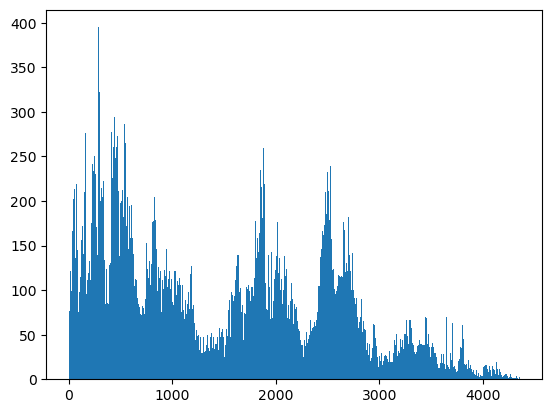

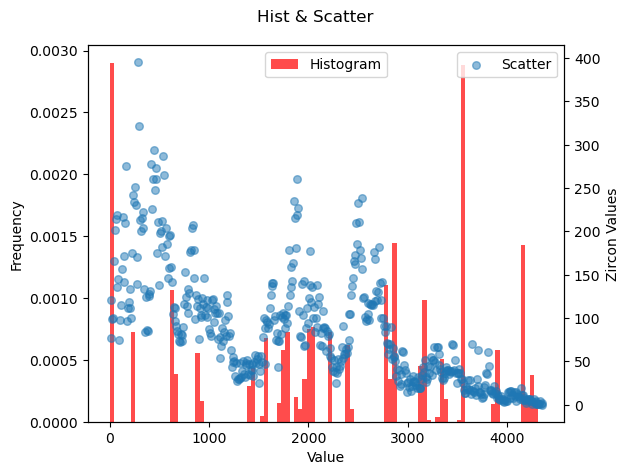

In [9]:
# 将八个维度合并起来 看后延分布
# 这样操作的motivation是，同一个拐点可能被不同维度switchpoint的后延分布分摊

switchpoint= switchpoints.flatten()

df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins=500)
zircons_data = data[0]
ages = data[1][1:]


# 创建图形和轴对象  
fig, ax1 = plt.subplots()

# 绘制 switchpoints 的直方图
n, bins, patches = ax1.hist(switchpoint, bins=100, density=True, alpha=0.7, color= 'red') 
ax1.legend(['Histogram'])

# 在twinx() axes对象上绘制 zircons 的散点图 
ax2 = ax1.twinx()  
ax2.scatter(ages, zircons_data, s=30 ,alpha=0.5)
ax2.legend(['Scatter'])

# 添加图例  
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Zircon Values')

# 调整布局

fig.suptitle('Hist & Scatter')
fig.subplots_adjust(hspace=0.5) 

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

# 显示图形
fig.tight_layout()
plt.show()

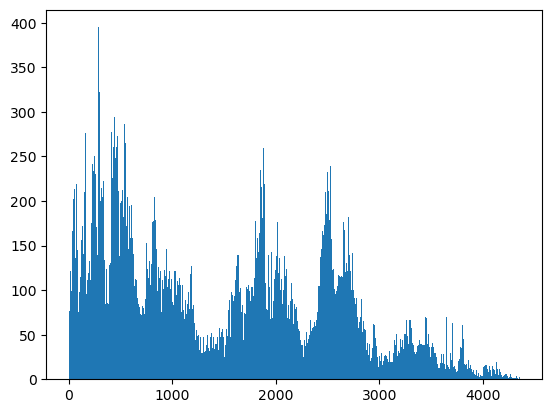

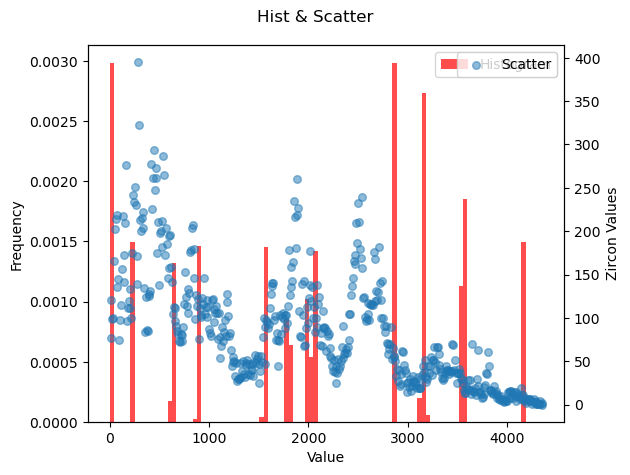

In [10]:
# 将八个维度合并起来 看后延分布
# 这样操作的motivation是，同一个拐点可能被不同维度switchpoint的后延分布分摊

switchpoint_b= switchpoints_b.flatten()

df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins=500)
zircons_data = data[0]
ages = data[1][1:]


# 创建图形和轴对象  
fig, ax1 = plt.subplots()

# 绘制 switchpoints 的直方图
n, bins, patches = ax1.hist(switchpoint_b, bins=100, density=True, alpha=0.7, color= 'red') 
ax1.legend(['Histogram'])

# 在twinx() axes对象上绘制 zircons 的散点图 
ax2 = ax1.twinx()  
ax2.scatter(ages, zircons_data, s=30 ,alpha=0.5)
ax2.legend(['Scatter'])

# 添加图例  
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Zircon Values')

# 调整布局

fig.suptitle('Hist & Scatter')
fig.subplots_adjust(hspace=0.5) 

#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

# 显示图形
fig.tight_layout()
plt.show()

In [11]:
# 构造表格数据
table_data = []
for i in range(8):
    table_data.append([f"Switchpoint {i+1}", variances[i], entropies_d[i]])

# 表格列头
headers = ["Component", "Variance", "Entropy"]

# 以 LaTeX 风格的表格输出
table = tabulate(table_data, headers, tablefmt="latex_raw")

# 添加 LaTeX 格式前缀和后缀
latex_table = r"""
\begin{table}[h]
    \centering
""" + table + r"""
    \caption{Variance and Entropy}
\end{table}
"""

print(latex_table)


\begin{table}[h]
    \centering
\begin{tabular}{lrr}
\hline
 Component     &    Variance &   Entropy \\
\hline
 Switchpoint 1 &     38.1255 &   262.918 \\
 Switchpoint 2 & 112739      &   986.455 \\
 Switchpoint 3 & 217130      &  1436.99  \\
 Switchpoint 4 &  10662.4    &  1547.48  \\
 Switchpoint 5 & 160411      &   699.758 \\
 Switchpoint 6 &  20799.7    &  1027.78  \\
 Switchpoint 7 &  39558.4    &  1519.03  \\
 Switchpoint 8 &  93739.8    &   812.586 \\
\hline
\end{tabular}
    \caption{Variance and Entropy}
\end{table}



In [12]:
# 构造表格数据
table_data = []
for i in range(8):
    table_data.append([f"Switchpoint {i+1}", variances[i], entropies_d[i]])

# 创建 pandas 数据框架
df = pd.DataFrame(table_data, columns=["Component", "Variance", "Entropy"])

# 在 Jupyter Notebook 中显示表格
display(df)

,Component,Variance,Entropy
0,Switchpoint 1,38.125495,[262.9183757156096]
1,Switchpoint 2,112739.350825,[986.4548080329731]
2,Switchpoint 3,217129.763853,[1436.9876259437347]
3,Switchpoint 4,10662.424862,[1547.4791010228203]
4,Switchpoint 5,160410.592912,[699.7580584822929]
5,Switchpoint 6,20799.651451,[1027.7788962391808]
6,Switchpoint 7,39558.350373,[1519.0322592740977]
7,Switchpoint 8,93739.814875,[812.586497095337]


In [13]:
print(pm.summary(loaded_data)['r_hat'])

rates[0]           1.14
rates[1]           2.64
rates[2]           2.91
rates[3]           2.87
rates[4]           2.88
rates[5]           2.86
rates[6]           2.33
rates[7]           2.43
rates[8]           2.18
switchpoints[0]    1.24
switchpoints[1]    3.82
switchpoints[2]    3.35
switchpoints[3]    2.93
switchpoints[4]    3.07
switchpoints[5]    2.84
switchpoints[6]    2.56
switchpoints[7]    2.46
Name: r_hat, dtype: float64
